In [1]:
# for this notebook make the path in the same folder (currently is in the project folder)
import os
import sys
import importlib

# Add the path to the val03 folder to sys.path so modules in the same folder can be imported
sys.path.append(os.path.join('notebooks', '103 different weighted'))

from scripts import style
importlib.reload(style)
style.set_style()

In [2]:
# STEP 0. Set up: import and reload py103, pull key functions

import importlib
import py103

# Always reload so edits to py103.py are picked up
importlib.reload(py103)

from py103 import (
    # Core data / transforms
    download_price_series,
    make_transformed_time_regression_data,
    TRANSFORM_FUNCS,

    # Core experiments
    run_transform_experiment,
    run_all_transforms_experiment,
    run_logprice_experiment,

    # Weighted training comparison
    run_weighted_training_comparison_single_transform,
    plot_weighted_training_comparison,

    # Normality-regularized selection
    run_normality_regularized_model_single_transform,

    # Residual diagnostics
    compute_validation_residuals_transform_and_price,
    compute_normality_stats,
    plot_validation_residual_diagnostics,

    # Plotting helpers
    plot_transform_trend,
    plot_destransformed_price_trend,
    subplot_all_transforms_and_destransforms,
)


In [3]:
# STEP 1. Basic: download NVDA and build (X, y, dates) for one transform

# 1A) Download NVDA close prices
df_nvda = download_price_series(
    ticker="AAPL",
    start="2015-01-01",
    end=None,          # up to latest available
)
print(df_nvda.head())
print(df_nvda.tail())
print(df_nvda.columns)

# 1B) Choose one transform (e.g. 'log_close') and build regression data
X_log, y_log, dates_log = make_transformed_time_regression_data(
    df=df_nvda,
    transform_name="log_close",   # any key in TRANSFORM_FUNCS
    price_col="close",
)

print("X_log shape:", X_log.shape)      # (n, 1)
print("y_log shape:", y_log.shape)      # (n,)
print("dates_log length:", len(dates_log))

# 1C) Inspect available transforms
print("Available transforms:", list(TRANSFORM_FUNCS.keys()))


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Price           close
Ticker           AAPL
Date                 
2015-01-02  24.237547
2015-01-05  23.554743
2015-01-06  23.556953
2015-01-07  23.887272
2015-01-08  24.805079
Price            close
Ticker            AAPL
Date                  
2025-11-21  271.489990
2025-11-24  275.920013
2025-11-25  276.970001
2025-11-26  277.549988
2025-11-28  278.850006
MultiIndex([('close', 'AAPL')],
           names=['Price', 'Ticker'])
X_log shape: (2744, 1)
y_log shape: (2744,)
dates_log length: 2744
Available transforms: ['close', 'log_close', 'sqrt_close', 'diff_close', 'simple_return', 'log_return', 'zscore_log_close']


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== AAPL Elastic Net trend on transform 'log_close' (degree=1) ===
Alpha=0.1000, l1_ratio=0.50
Variance of transformed series: 6.634909e-01

--- Metrics in TRANSFORM space (y_t) and PRICE space (Close) ---
[train    ]  y: RMSE=0.207226, lin=0.233821, exp=0.245119   |  price: RMSE=15.734229, lin=20.798933, exp=22.314922
[val      ]  y: RMSE=0.286299, lin=0.220452, exp=0.223963   |  price: RMSE=38.309362, lin=31.548384, exp=32.000945
[test     ]  y: RMSE=0.110149, lin=0.106856, exp=0.103600   |  price: RMSE=22.833514, lin=23.105536, exp=22.354391
[train_val]  y: RMSE=0.229543, lin=0.254003, exp=0.252471   |  price: RMSE=23.501026, lin=29.248338, exp=29.508581

[log_close] variance: 0.6634909135012662

=== Transform-space RMSE metrics (y_t) for log_close ===
train     | RMSE=0.207226, lin=0.233821, exp=0.245119
val       | RMSE=0.286299, lin=0.220452, exp=0.223963
test      | RMSE=0.110149, lin=0.106856, exp=0.103600
train_val | RMSE=0.229543, lin=0.254003, exp=0.252471


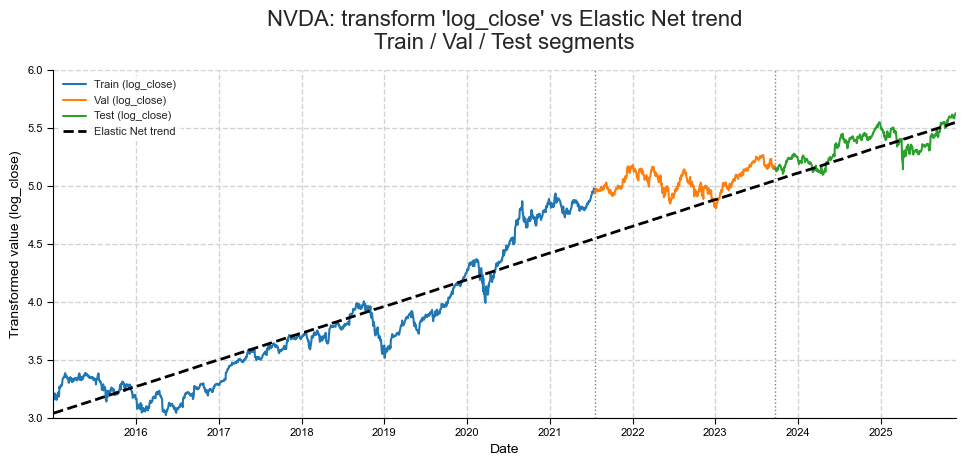

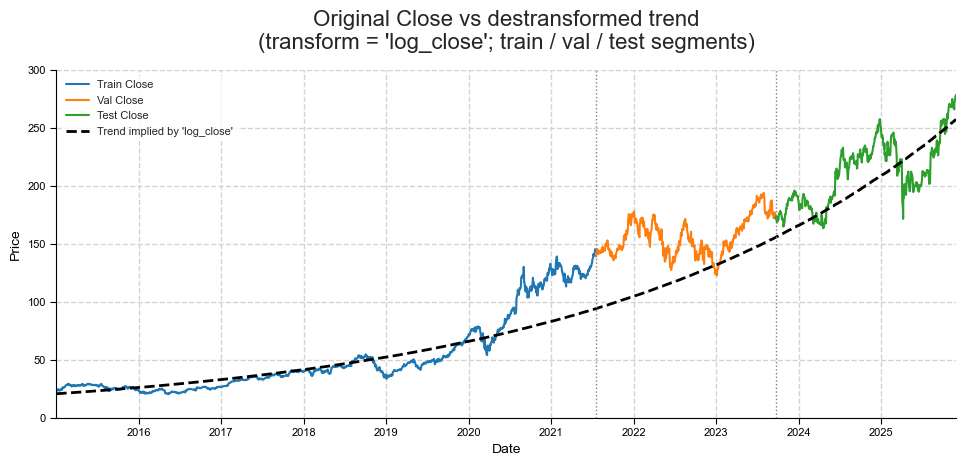

In [4]:
# STEP 2. Single-transform Elastic Net experiment + plots (transform & price space)

# 2A) Run full pipeline for ONE transform (e.g. 'log_close')
log_result, log_model, df_nvda = run_transform_experiment(
    transform_name="log_close",
    ticker="AAPL",
    start="2015-01-01",
    end=None,
    alpha=0.1,
    l1_ratio=0.5,
    random_state=0,
    train_frac=0.6,
    val_frac=0.2,
    poly_degree=1,         # 1 = linear in time; can try 2,3,...
)

# log_result["variance"] = variance of transformed series
print("\n[log_close] variance:", log_result["variance"])

# log_result["metrics"] is a dict with keys: 'train', 'val', 'test', 'train_val'
# Each entry has: rmse, rmse_w_linear, rmse_w_exp (all in TRANSFORM space)
print("\n=== Transform-space RMSE metrics (y_t) for log_close ===")
for split_name, m in log_result["metrics"].items():
    print(
        f"{split_name:9s} | "
        f"RMSE={m['rmse']:.6f}, "
        f"lin={m['rmse_w_linear']:.6f}, "
        f"exp={m['rmse_w_exp']:.6f}"
    )

# 2B) Plot in TRANSFORM space with colored train/val/test
plot_transform_trend(
    df=df_nvda,
    model=log_model,
    transform_name="log_close",
    train_frac=0.6,
    val_frac=0.2,
)

# 2C) Plot in PRICE space (detransformed trend vs Close)
plot_destransformed_price_trend(
    df=df_nvda,
    model=log_model,
    transform_name="log_close",
    train_frac=0.6,
    val_frac=0.2,
)


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== NVDA transform 'close' (degree=2) ===
Variance: 2.324785e+03
--- TRAIN / VAL / TEST metrics (transform vs price) ---
[train    ]  y: RMSE=1.820796, lin=2.252493, exp=2.307388   |  price: RMSE=1.820796, lin=2.252493, exp=2.307388
[val      ]  y: RMSE=10.926589, lin=12.736030, exp=13.681099   |  price: RMSE=10.926589, lin=12.736030, exp=13.681099
[test     ]  y: RMSE=98.547953, lin=115.667068, exp=117.648842   |  price: RMSE=98.547953, lin=115.667068, exp=117.648842

=== NVDA transform 'log_close' (degree=2) ===
Variance: 2.742335e+00
--- TRAIN / VAL / TEST metrics (transform vs price) ---
[train    ]  y: RMSE=0.380285, lin=0.337416, exp=0.324839   |  price: RMSE=1.603957, lin=1.851242, exp=1.850685
[val      ]  y: RMSE=0.395646, lin=0.397221, exp=0.375377   |  price: RMSE=8.759560, lin=9.001509, exp=8.638061
[test     ]  y: RMSE=0.466980, lin=0.490752, exp=0.480235   |  price: RMSE=49.782919, lin=56.981613, exp=57.410483

=== NVDA transform 'sqrt_close' (degree=2) ===
Variance: 1.2

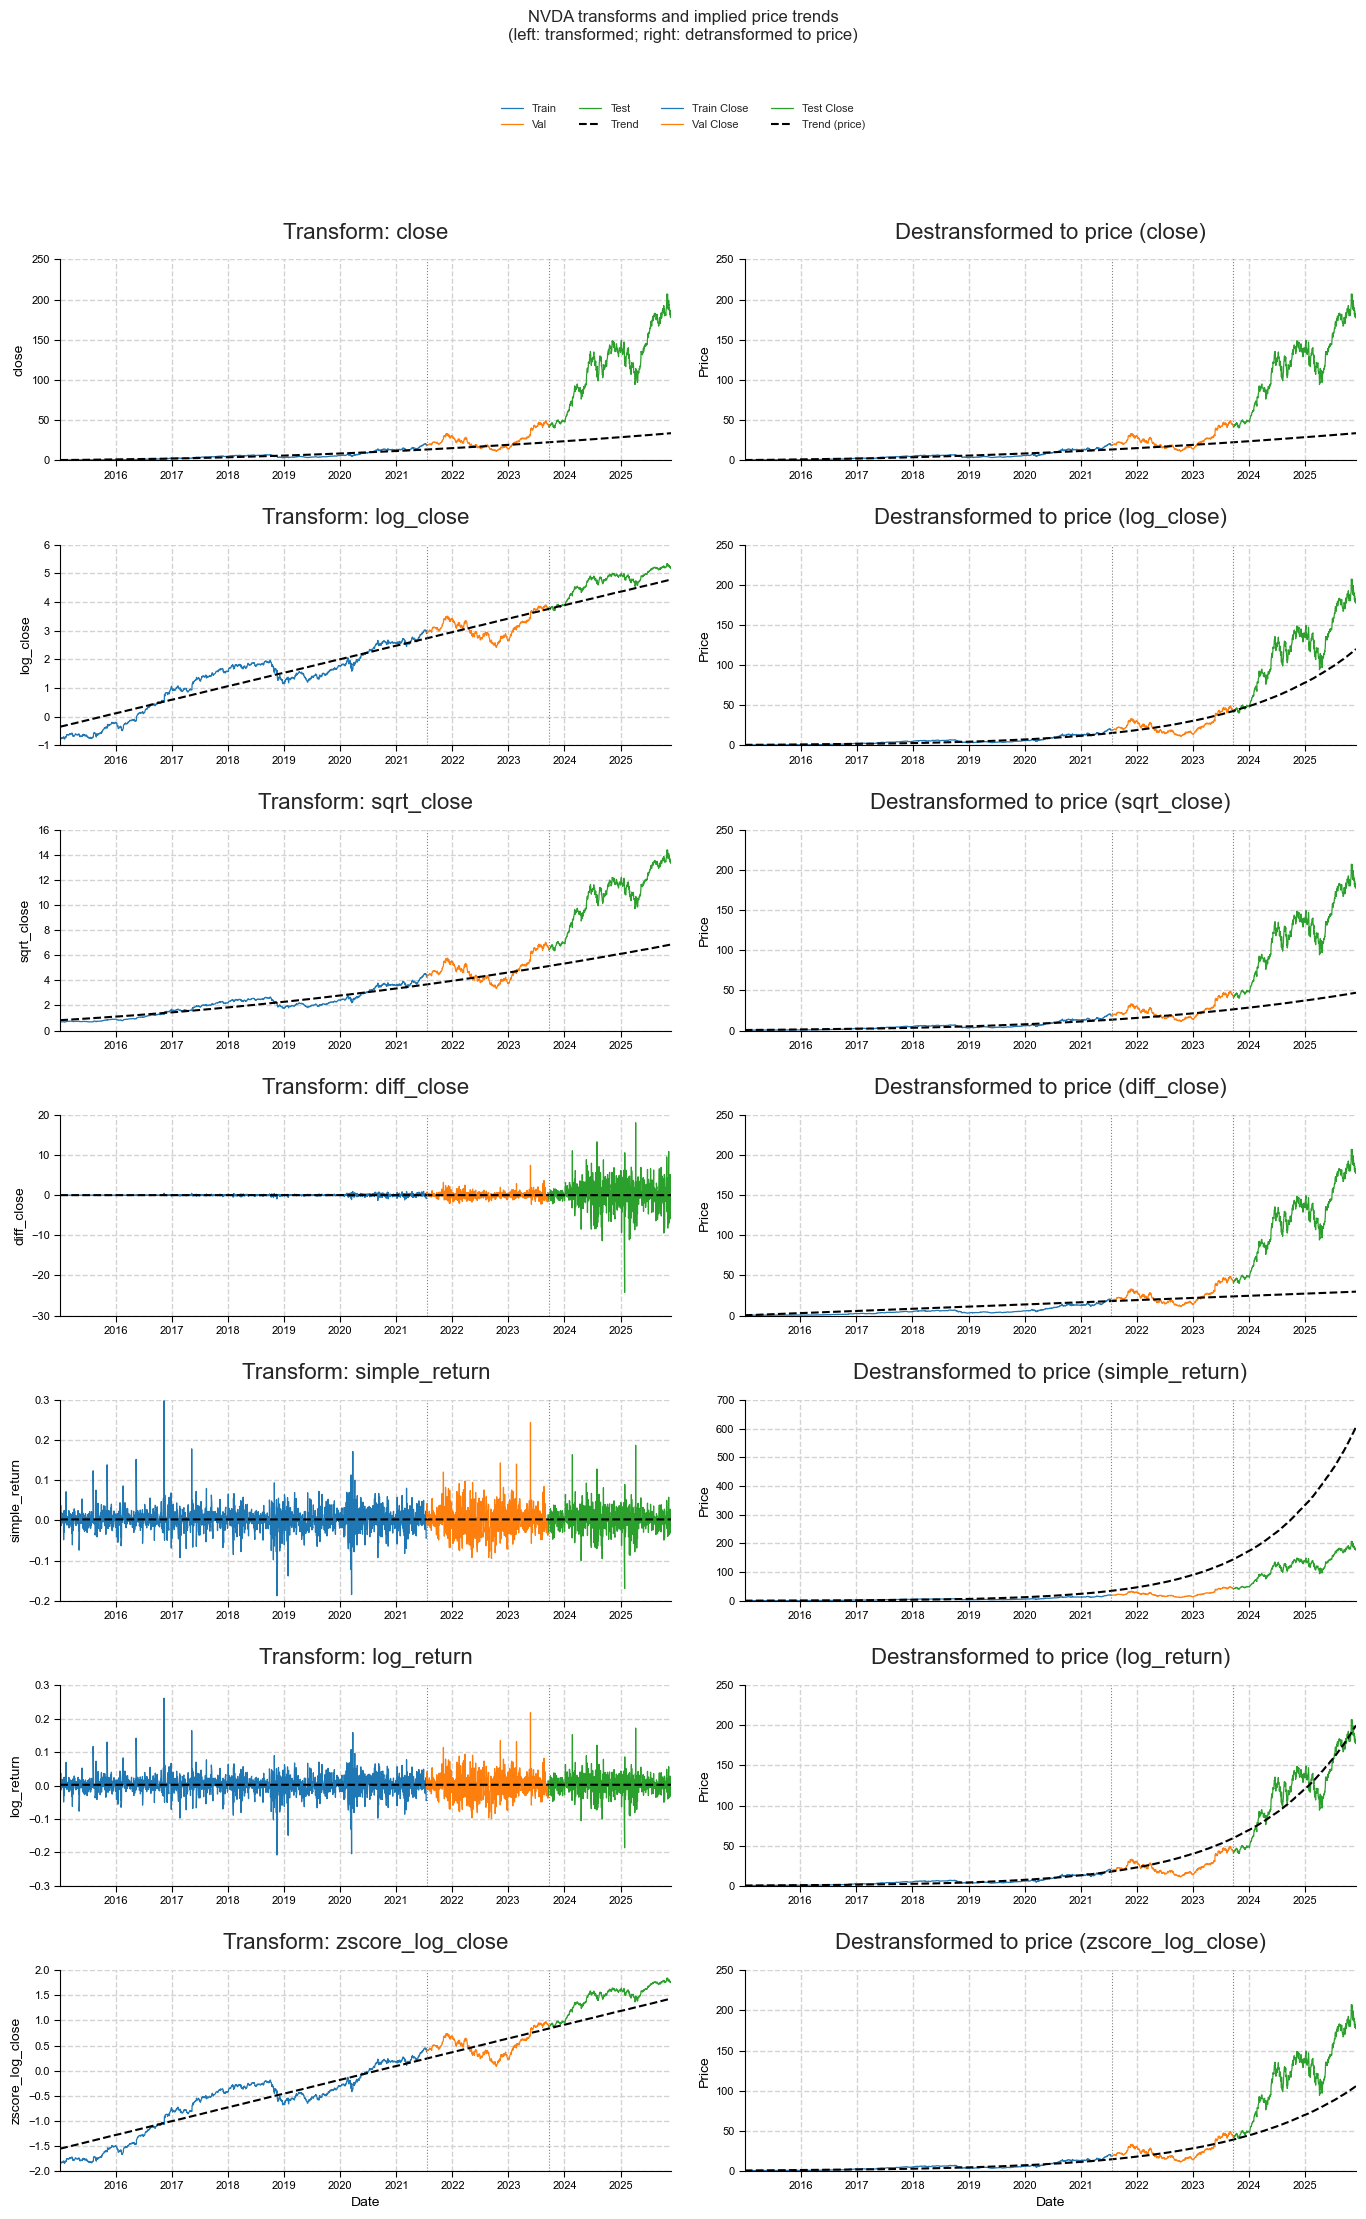

In [42]:
# STEP 3. Multi-transform experiment: compare all transforms numerically

# 3A) Run the experiment over ALL transforms in TRANSFORM_FUNCS
all_results, all_models, df_all = run_all_transforms_experiment(
    transform_names=None,      # None => use all transforms in TRANSFORM_FUNCS
    ticker="NVDA",
    start="2015-01-01",
    end=None,
    alpha=0.1,
    l1_ratio=0.5,
    random_state=0,
    train_frac=0.6,
    val_frac=0.2,
    poly_degree=2,
)

# all_results[transform_name] has:
#   - 'variance'
#   - 'metrics' (rmse, rmse_w_linear, rmse_w_exp for train/val/test/train_val)
print("\n=== SUMMARY: test RMSE in TRANSFORM space for each transform ===")
for name, res in all_results.items():
    m_test = res["metrics"]["test"]
    print(
        f"{name:16s} | "
        f"RMSE={m_test['rmse']:.6f}, "
        f"lin={m_test['rmse_w_linear']:.6f}, "
        f"exp={m_test['rmse_w_exp']:.6f}"
    )

# 3B) Global visualization: each transform in a row, with transform & price panels
subplot_all_transforms_and_destransforms(
    df=df_all,
    models=all_models,
    transform_names=None,   # None => all transforms
    train_frac=0.6,
    val_frac=0.2,
)


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== Weighted-training comparison for transform 'log_close' (degree=1) ===
Alpha=0.1000, l1_ratio=0.50, ratio_last_first=10.0
[mode=plain ]  VAL y: RMSE=0.395646, lin=0.397221, exp=0.375377   |  VAL price: RMSE=8.759559, lin=9.001509, exp=8.638061
[mode=linear]  VAL y: RMSE=0.382586, lin=0.350279, exp=0.359162   |  VAL price: RMSE=9.022410, lin=9.610395, exp=10.172564
[mode=exp   ]  VAL y: RMSE=0.366483, lin=0.343919, exp=0.336861   |  VAL price: RMSE=8.225706, lin=8.405513, exp=8.565215

=== Weighted-training comparison in TRANSFORM and PRICE space ===
Mode=plain  | y_val: RMSE=0.395646, lin=0.397221, exp=0.375377   ||   price_val: RMSE=2602.762585, lin=3167.439080, exp=3265.681618
Mode=linear | y_val: RMSE=0.382586, lin=0.350279, exp=0.359162   ||   price_val: RMSE=1585.430858, lin=1880.655068, exp=1925.774792
Mode=exp    | y_val: RMSE=0.366483, lin=0.343919, exp=0.336861   ||   price_val: RMSE=1989.274746, lin=2388.279403, exp=2453.152253


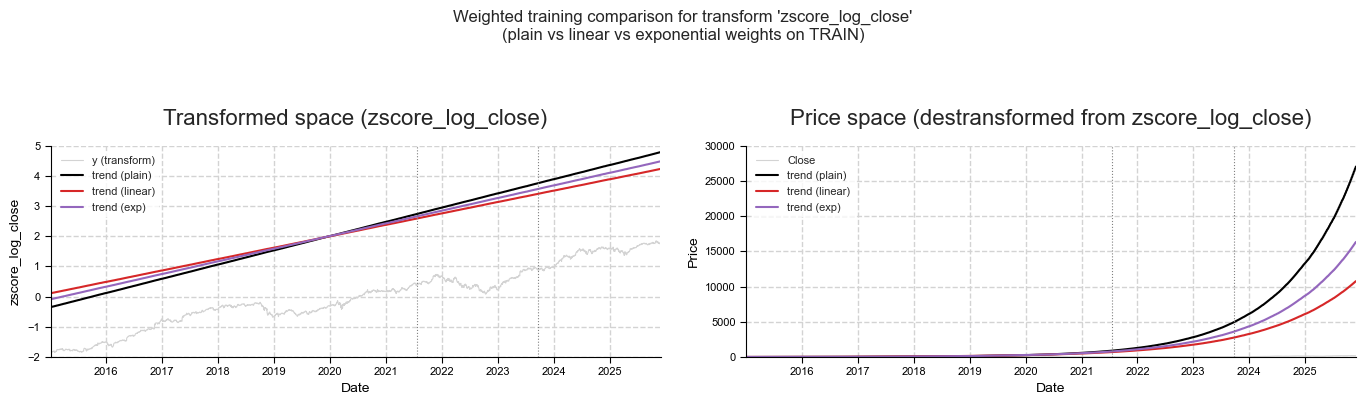

In [43]:
# STEP 4 (FIXED). Weighted training vs plain training (plain / linear / exp)

import importlib
import py103

importlib.reload(py103)

from py103 import (
    run_weighted_training_comparison_single_transform,
    plot_weighted_training_comparison,
    compute_price_space_metrics_for_model,
)

# 4A) Run weighted-training comparison for ONE transform (e.g. 'log_close')
wt_results, wt_models, df_wt = run_weighted_training_comparison_single_transform(
    transform_name="log_close",
    ticker="NVDA",
    start="2015-01-01",
    end=None,
    alpha=0.1,
    l1_ratio=0.5,
    random_state=0,
    train_frac=0.6,
    val_frac=0.2,
    ratio_last_first=10.0,   # exp weights: last / first weight ratio
    poly_degree=1,
)

print("\n=== Weighted-training comparison in TRANSFORM and PRICE space ===")
for mode, metrics_y in wt_results.items():
    # metrics_y is a dict by split: 'train', 'val', 'test', 'train_val'
    m_y_val = metrics_y["val"]

    # Compute PRICE-space metrics for this mode/model
    price_metrics = compute_price_space_metrics_for_model(
        df=df_wt,
        model=wt_models[mode],
        transform_name="zscore_log_close",
        train_frac=0.6,
        val_frac=0.2,
        ratio_last_first=10.0,
    )
    m_p_val = price_metrics["val"]

    print(
        f"Mode={mode:6s} | "
        f"y_val: RMSE={m_y_val['rmse']:.6f}, "
        f"lin={m_y_val['rmse_w_linear']:.6f}, "
        f"exp={m_y_val['rmse_w_exp']:.6f}   ||   "
        f"price_val: RMSE={m_p_val['rmse']:.6f}, "
        f"lin={m_p_val['rmse_w_linear']:.6f}, "
        f"exp={m_p_val['rmse_w_exp']:.6f}"
    )

# 4B) Plot the three training schemes together (transform + price panels)
plot_weighted_training_comparison(
    df=df_wt,
    models_by_mode=wt_models,
    transform_name="zscore_log_close",
    train_frac=0.6,
    val_frac=0.2,
)


In [ ]:
print("\n=== Weighted-training comparison in TRANSFORM and PRICE space ===")
for mode, metrics_y in wt_results.items():
    # metrics_y is a dict by split: 'train', 'val', 'test', 'train_val'
    m_y_val = metrics_y["val"]

    # Compute PRICE-space metrics for this mode/model
    price_metrics = compute_price_space_metrics_for_model(
        df=df_wt,
        model=wt_models[mode],
        transform_name="log_close",
        train_frac=0.6,
        val_frac=0.2,
        ratio_last_first=10.0,
    )
    m_p_val = price_metrics["val"]

    print(
        f"Mode={mode:6s} | "
        f"y_val: RMSE={m_y_val['rmse']:.6f}, "
        f"lin={m_y_val['rmse_w_linear']:.6f}, "
        f"exp={m_y_val['rmse_w_exp']:.6f}   ||   "
        f"price_val: RMSE={m_p_val['rmse']:.6f}, "
        f"lin={m_p_val['rmse_w_linear']:.6f}, "
        f"exp={m_p_val['rmse_w_exp']:.6f}"
    )

# 4B) Plot the three training schemes together (transform + price panels)
plot_weighted_training_comparison(
    df=df_wt,
    models_by_mode=wt_models,
    transform_name="log_close",
    train_frac=0.6,
    val_frac=0.2,
)


Validation residuals (transform space) length: 548
Validation residuals (price space) length: 548

=== Normality stats (price-space validation residuals) ===
n            : 548
mean         : -7398.353138
std          : 753.368821
skew         : -0.014808
kurt_excess  : -1.232247
jb_stat      : 34.674715
jb_pvalue    : 0.000000

=== Validation residual diagnostics (price, transform='diff_close') ===
n = 548
mean(resid) = -7.398353e+03
std(resid)  = 7.533688e+02
t-stat (H0: mean=0) = -229.8887,  p-value = 0.0000
skewness = -0.0148,  excess kurtosis = -1.2322


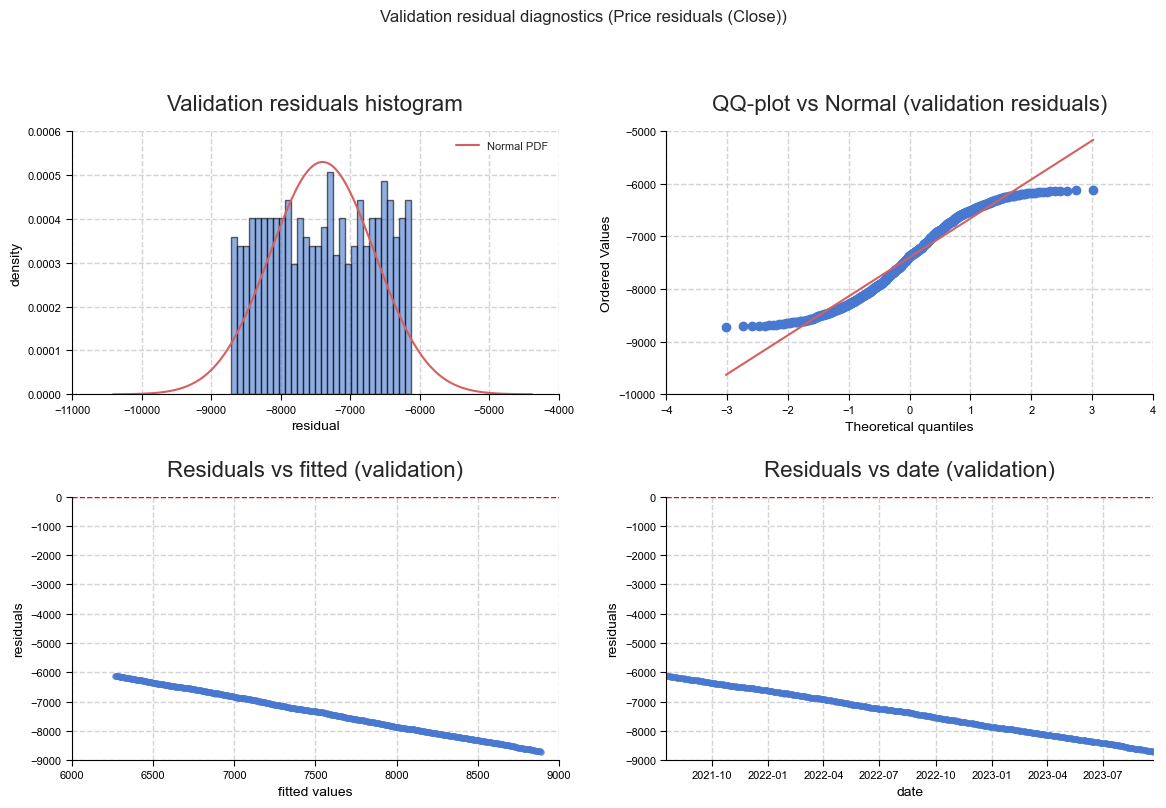

In [8]:
# STEP 5. Residual diagnostics on the VALIDATION set (normality etc.)

# Here we reuse the log_model from STEP 2.
# You can also plug in any model from all_models or wt_models.

# 5A) Get validation residuals in transform & price space
res_val = compute_validation_residuals_transform_and_price(
    df=df_nvda,
    model=log_model,
    transform_name="diff_close",
    train_frac=0.6,
    val_frac=0.2,
)

resid_y_val = res_val["resid_y_val"]
resid_p_val = res_val["resid_p_val"]

print("Validation residuals (transform space) length:", resid_y_val.shape[0])
print("Validation residuals (price space) length:", resid_p_val.shape[0])

# 5B) Compute normality diagnostics (Jarque-Bera etc.) for price residuals
stats_price = compute_normality_stats(resid_p_val)
print("\n=== Normality stats (price-space validation residuals) ===")
for k, v in stats_price.items():
    print(f"{k:12s} : {v:.6f}" if isinstance(v, float) else f"{k:12s} : {v}")

# 5C) Full residual diagnostic plots (hist, QQ, residuals vs fitted/date)
#     space='transform' or 'price'
plot_validation_residual_diagnostics(
    df=df_nvda,
    model=log_model,
    transform_name="diff_close",
    space="price",       # or "transform"
    train_frac=0.6,
    val_frac=0.2,
)


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== Normality-regularized model selection for transform 'diff_close' (normality_space=transform) ===
Grids: alpha=[0.01, 0.1, 1.0], l1_ratio=[0.1, 0.5, 0.9], degree=[1, 2, 3], weights=['plain', 'linear', 'exp']
Objective: obj = 1.0 * RMSE_val_price + 1.0 * JB_stat

alpha=0.01, l1=0.10, deg=1, wmode=plain       | VAL price RMSE=8.396808 | JB=2250.702, p=0.000 | obj=2259.098994
alpha=0.01, l1=0.10, deg=1, wmode=linear      | VAL price RMSE=8.389767 | JB=2247.903, p=0.000 | obj=2256.292646
alpha=0.01, l1=0.10, deg=1, wmode=exp         | VAL price RMSE=8.698767 | JB=2247.967, p=0.000 | obj=2256.665546
alpha=0.01, l1=0.10, deg=2, wmode=plain       | VAL price RMSE=9.296262 | JB=2241.507, p=0.000 | obj=2250.803637
alpha=0.01, l1=0.10, deg=2, wmode=linear      | VAL price RMSE=9.421257 | JB=2237.330, p=0.000 | obj=2246.750967
alpha=0.01, l1=0.10, deg=2, wmode=exp         | VAL price RMSE=9.914290 | JB=2237.091, p=0.000 | obj=2247.005679
alpha=0.01, l1=0.10, deg=3, wmode=plain       | VAL pri

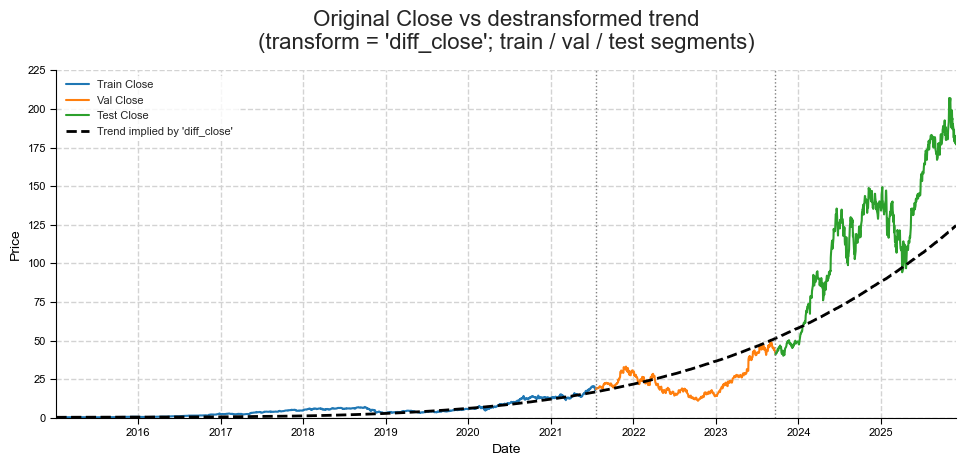


=== Validation residual diagnostics (transform, transform='diff_close') ===
n = 548
mean(resid) = -1.909565e-02
std(resid)  = 8.788045e-01
t-stat (H0: mean=0) = -0.5087,  p-value = 0.6112
skewness = 1.3975,  excess kurtosis = 9.5575


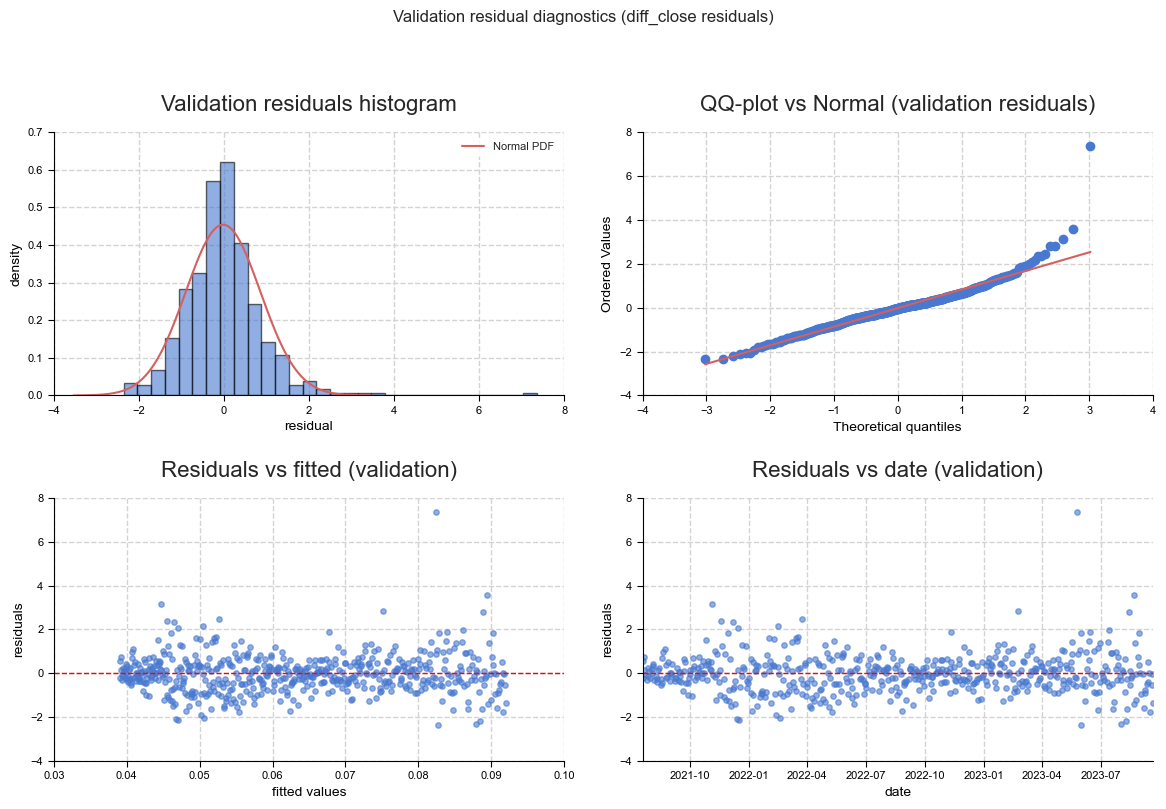

In [15]:
# STEP 6. Normality-regularized model selection
#         (jointly optimizing RMSE + residual normality)

best_summary, best_model, all_candidates, df_norm = (
    run_normality_regularized_model_single_transform(
        transform_name="diff_close",
        ticker="NVDA",
        start="2015-01-01",
        end=None,
        alpha_grid=(0.01, 0.1, 1.0),
        l1_ratio_grid=(0.1, 0.5, 0.9),
        poly_degree_grid=(1, 2, 3),
        train_weight_modes=("plain", "linear", "exp"),
        train_frac=0.6,
        val_frac=0.2,
        random_state=0,
        ratio_last_first=10.0,
        w_rmse=1.0,        # weight on validation RMSE in price space
        w_jb=1.0,          # weight on Jarque-Bera statistic
        normality_space="transform",  # or "transform"
    )
)

print("\n=== BEST CONFIG (RMSE + normality) ===")
for k, v in best_summary.items():
    print(f"{k:18s} : {v}")

# Optionally, inspect some candidate configs:
print("\nNumber of candidate models:", len(all_candidates))
some_key = next(iter(all_candidates.keys()))
print("\nExample candidate:", some_key)
for k, v in all_candidates[some_key].items():
    print(f"  {k:18s} : {v}")

# Plot diagnostics for the best_model in price space
plot_destransformed_price_trend(
    df=df_norm,
    model=best_model,
    transform_name="diff_close",
    train_frac=0.6,
    val_frac=0.2,
)

plot_validation_residual_diagnostics(
    df=df_norm,
    model=best_model,
    transform_name="diff_close",
    space="transform",
    train_frac=0.6,
    val_frac=0.2,
)


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== ORCL Elastic Net trend on transform 'log_close' (degree=4) ===
Alpha=0.1000, l1_ratio=0.50
Variance of transformed series: 3.113948e-01

--- Metrics in TRANSFORM space (y_t) and PRICE space (Close) ---
[train    ]  y: RMSE=0.094500, lin=0.099423, exp=0.105502   |  price: RMSE=4.717865, lin=5.742874, exp=6.229549
[val      ]  y: RMSE=0.191833, lin=0.154539, exp=0.168118   |  price: RMSE=15.430335, lin=14.136330, exp=15.344119
[test     ]  y: RMSE=0.220072, lin=0.265646, exp=0.273131   |  price: RMSE=42.703956, lin=54.390436, exp=56.946460
[train_val]  y: RMSE=0.126061, lin=0.144367, exp=0.146965   |  price: RMSE=8.727445, lin=10.965423, exp=11.363565


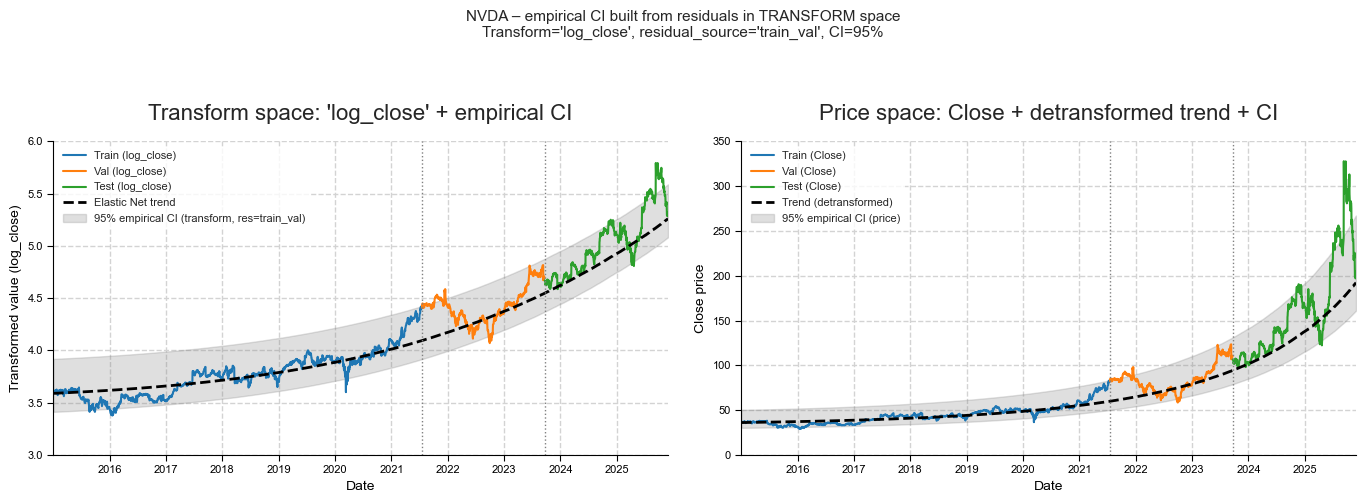


=== Validation residual diagnostics (price, transform='log_close') ===
n = 548
mean(resid) = 9.789292e+00
std(resid)  = 1.193839e+01
t-stat (H0: mean=0) = 19.1953,  p-value = 0.0000
skewness = 0.0757,  excess kurtosis = -1.0874


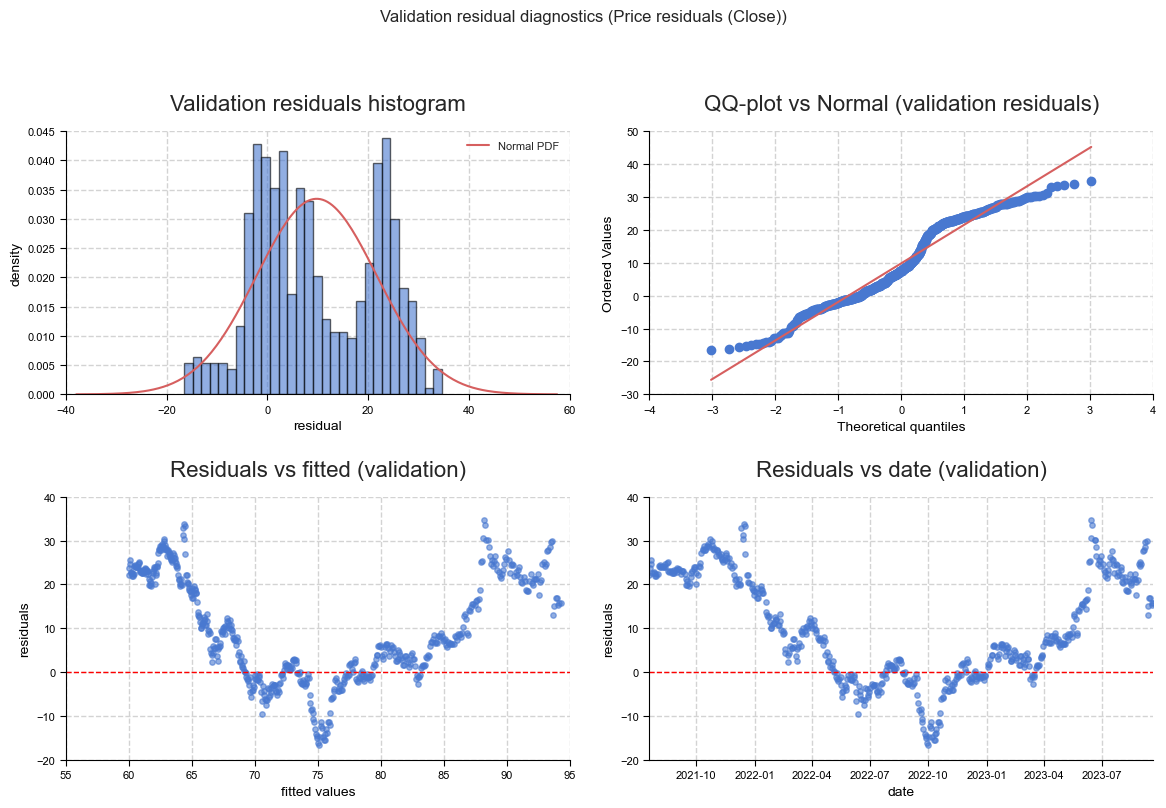

In [36]:
# EXAMPLE USAGE in your notebook

import importlib
import py103

importlib.reload(py103)

from py103 import (
    run_transform_experiment,
    plot_transform_trend_with_empirical_ci,
)

# 1) Fit the model in TRANSFORM space (e.g. log_close)
log_result, log_model, df_nvda = run_transform_experiment(
    transform_name="log_close",
    ticker="ORCL",
    start="2015-01-01",
    end=None,
    alpha=0.1,
    l1_ratio=0.5,
    random_state=0,
    train_frac=0.6,
    val_frac=0.2,
    poly_degree=4,
)


# 2) Plot:
#    LEFT  = log_close series, trend, empirical CI (residuals in log space)
#    RIGHT = Close series, detransformed trend, CI mapped to price space
plot_transform_trend_with_empirical_ci(
    df=df_nvda,
    model=log_model,
    transform_name="log_close",
    train_frac=0.6,
    val_frac=0.2,
    ci_level=0.95,
    residual_source="train_val",  # or "train" or "all"
)


plot_validation_residual_diagnostics(
    df=df_nvda,
    model=log_model,
    transform_name="log_close",
    space="price",
    train_frac=0.6,
    val_frac=0.2,
)

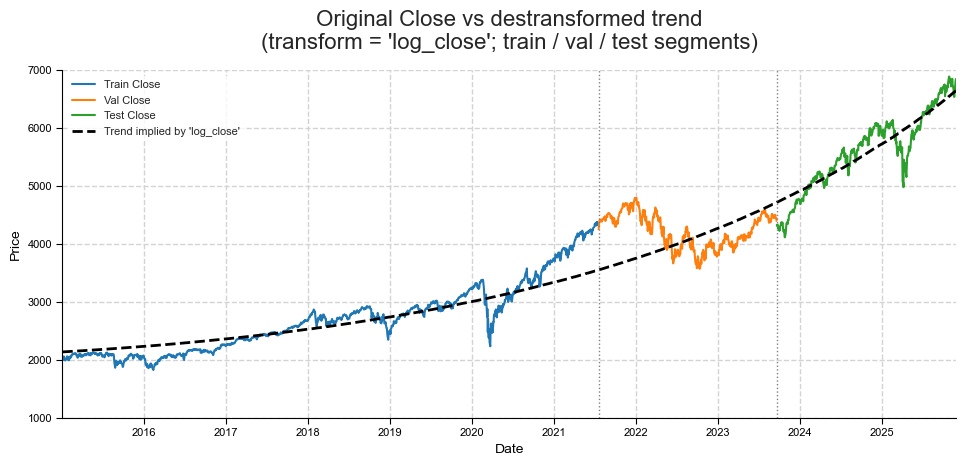

In [30]:
plot_destransformed_price_trend(
    df = df_nvda,
    model = log_model,
    transform_name = "log_close",
    train_frac = 0.6,
    val_frac = 0.2,
) 

In [40]:
from py103 import print_normality_tests_all_splits

print_normality_tests_all_splits(
    df = df_nvda,
    model = log_model,
    transform_name = "log_close",
    space = "transform",
    train_frac = 0.6,
    val_frac = 0.2,
)


=== Normality tests for residuals in transform-space (transform='log_close') ===
[train    ] n=1646, mean=-2.849e-16, std=9.453e-02, t=-0.000, p_t=1.000, JB=57.316, p_JB=0.000, skew=0.290, kurt_excess=0.712
[val      ] n= 548, mean=1.179e-01, std=1.515e-01, t=18.212, p_t=0.000, JB=17.084, p_JB=0.000, skew=0.031, kurt_excess=-0.860
[test     ] n= 550, mean=1.610e-01, std=1.502e-01, t=25.148, p_t=0.000, JB=20.777, p_JB=0.000, skew=0.477, kurt_excess=-0.022
[train_val] n=2194, mean=2.944e-02, std=1.226e-01, t=11.247, p_t=0.000, JB=210.560, p_JB=0.000, skew=0.701, kurt_excess=0.587


{'train': {'n': 1646,
  'mean': -2.8490777983090287e-16,
  'std': 0.09452851123122409,
  'skew': 0.2904808026852184,
  'kurt_excess': 0.7120684164398852,
  'jb_stat': 57.31581403784229,
  'jb_pvalue': 3.581204477303511e-13,
  't_stat_mean0': np.float64(-1.2228027474079898e-13),
  't_pvalue_mean0': np.float64(0.9999999999999025)},
 'val': {'n': 548,
  'mean': 0.1178607930531969,
  'std': 0.1514942536144311,
  'skew': 0.031050488951368416,
  'kurt_excess': -0.859657330801773,
  'jb_stat': 17.083784376101796,
  'jb_pvalue': 0.0001951207055563101,
  't_stat_mean0': np.float64(18.212244768545947),
  't_pvalue_mean0': np.float64(2.779970495360399e-58)},
 'test': {'n': 550,
  'mean': 0.1610148257959169,
  'std': 0.1501558227132623,
  'skew': 0.47710365468852295,
  'kurt_excess': -0.021954471531765662,
  'jb_stat': 20.77656747180665,
  'jb_pvalue': 3.079113494415156e-05,
  't_stat_mean0': np.float64(25.148091590180083),
  't_pvalue_mean0': np.float64(2.0134414333794784e-93)},
 'train_val': {'n

c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== NVDA Elastic Net trend on transform 'diff_close' (degree=1) ===
Alpha=0.1000, l1_ratio=0.50
Variance of transformed series: 2.914640e+00

--- Metrics in TRANSFORM space (y_t) and PRICE space (Close) ---
[train    ]  y: RMSE=0.188369, lin=0.241613, exp=0.253481   |  price: RMSE=4.819408, lin=5.479355, exp=5.333566
[val      ]  y: RMSE=0.879167, lin=0.938946, exp=0.961691   |  price: RMSE=9.500766, lin=11.702973, exp=12.492084
[test     ]  y: RMSE=3.697864, lin=4.043686, exp=3.983113   |  price: RMSE=100.011699, lin=117.782743, exp=119.888981
[train_val]  y: RMSE=0.468788, lin=0.614499, exp=0.649063   |  price: RMSE=6.322857, lin=7.699558, exp=8.070195


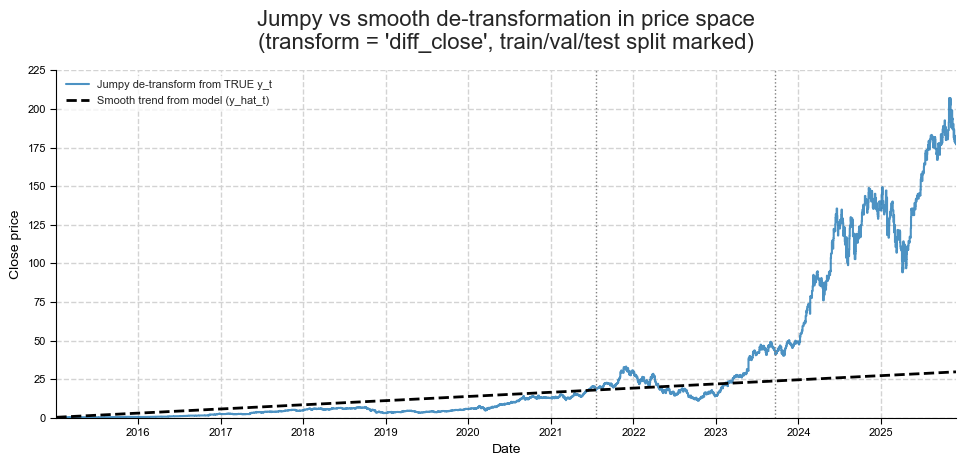

In [41]:
import importlib
import py103

importlib.reload(py103)

from py103 import (
    run_transform_experiment,
    plot_jumpy_detransformed_price_trend,
)

# Example: fit on log_close (you can also try 'diff_close', 'log_return', etc.)
log_result, log_model, df_nvda = run_transform_experiment(
    transform_name="diff_close",   # try also 'log_close', 'log_return', ...
    ticker="NVDA",
    start="2015-01-01",
    end=None,
    alpha=0.1,
    l1_ratio=0.5,
    random_state=0,
    train_frac=0.6,
    val_frac=0.2,
    poly_degree=1,
)

# Jumpy vs smooth price-space plot
plot_jumpy_detransformed_price_trend(
    df=df_nvda,
    model=log_model,
    transform_name="diff_close",   # same as above
    train_frac=0.6,
    val_frac=0.2,
    use_step=True,                 # step plot to emphasize the jumps
)
